# **SemEval: 2025**



---

**Import the necessary libraries.**

---

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


---

**Load the datasets.**

---



We have 3 csv files:
    
1. Train labeled dataset:  Contains the labeled data, where both the text (title or full text) and the associated labels (e.g., hazard-category, product-category) are available.
2. Validation unlabeled dataset: Contains unlabeled data that will be used to evaluate the model’s performance.
3. Test unlabeled dataset: Contains data will be used to make final predictions. This file also lacks labels, and the predictions will be submitted for evaluation.

In order to explore our data, we are going to load the csv files.




In [14]:
# url of train labeled dataset
url_labeled_data = 'https://raw.githubusercontent.com/LefkiAth/Semeval2025/refs/heads/main/labeled_trial-training_data(5028samples).csv'
# load training data
train_data = pd.read_csv(url_labeled_data)

train_data.head()
# url of unlabeled test set
url_testset = 'https://raw.githubusercontent.com/LefkiAth/Semeval2025/refs/heads/main/unlabeled_test_data(997).csv'
# load the test data
test_data = pd.read_csv(url_testset)

test_data.head()
# url of unlabeled validation set
url_validation_set = 'https://raw.githubusercontent.com/LefkiAth/Semeval2025/refs/heads/main/unlabeled_validation_data(565).csv'
# load the validation data
validation_data = pd.read_csv(url_validation_set)

validation_data.head()

,Unnamed: 0,year,month,day,country,title,text
0,0,1994,5,5,us,Recall Notification: FSIS-017-94,Case Number: 017-94 \n Date Opene...
1,1,1994,5,12,us,Recall Notification: FSIS-048-94,Case Number: 048-94 \n Date Opene...
2,2,1995,4,16,us,Recall Notification: FSIS-032-95,Case Number: 032-95 \n Date Opene...
3,3,1998,7,16,ca,Archive - ALLERGY ALERT -- PRESENCE OF UNDECLA...,PRESENCE OF UNDECLARED NUTS IN ORIGINALE AUGUS...
4,4,1998,8,6,us,Recall Notification: FSIS-018-98,Case Number: 018-98 Recall Notification Repor...


---

**Preprocessing**

---

1. **Data Loading and Cleaning**

We began by loading the training dataset, which included columns like title, text, hazard-category, and product-category. After loading the data, we cleaned it by removing unnecessary columns (such as Unnamed: 0, which likely represented an index column) and normalizing the text data. Specifically:
* Text normalization: All text in the title and text columns was converted to lowercase, and extra spaces were removed to standardize the dataset for analysis.

In [15]:
# Step 1: Preprocessing
# Drop unnecessary columns
columns_to_drop = ['Unnamed: 0']
train_data_cleaned = train_data.drop(columns=columns_to_drop)


# Normalize text fields (lowercasing and stripping extra spaces)
train_data_cleaned["title"] = train_data_cleaned["title"].str.lower().str.strip()
train_data_cleaned["text"] = train_data_cleaned["text"].str.lower().str.strip()

# Compute text lengths
train_data_cleaned["title_length"] = train_data_cleaned["title"].str.split().apply(len)
train_data_cleaned["text_length"] = train_data_cleaned["text"].str.split().apply(len)


2. **Basic Text Length Analysis**

To better understand the length of both titles and full texts, we calculated the number of words in each title and text. We then visualized the distributions of these text lengths using histograms and computed the mean values.


C:\Users\magda\AppData\Local\Temp\ipykernel_57208\3296920505.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=hazard_category_counts.index, y=hazard_category_counts.values, palette="viridis")
C:\Users\magda\AppData\Local\Temp\ipykernel_57208\3296920505.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=product_category_counts.index, y=product_category_counts.values, palette="plasma")


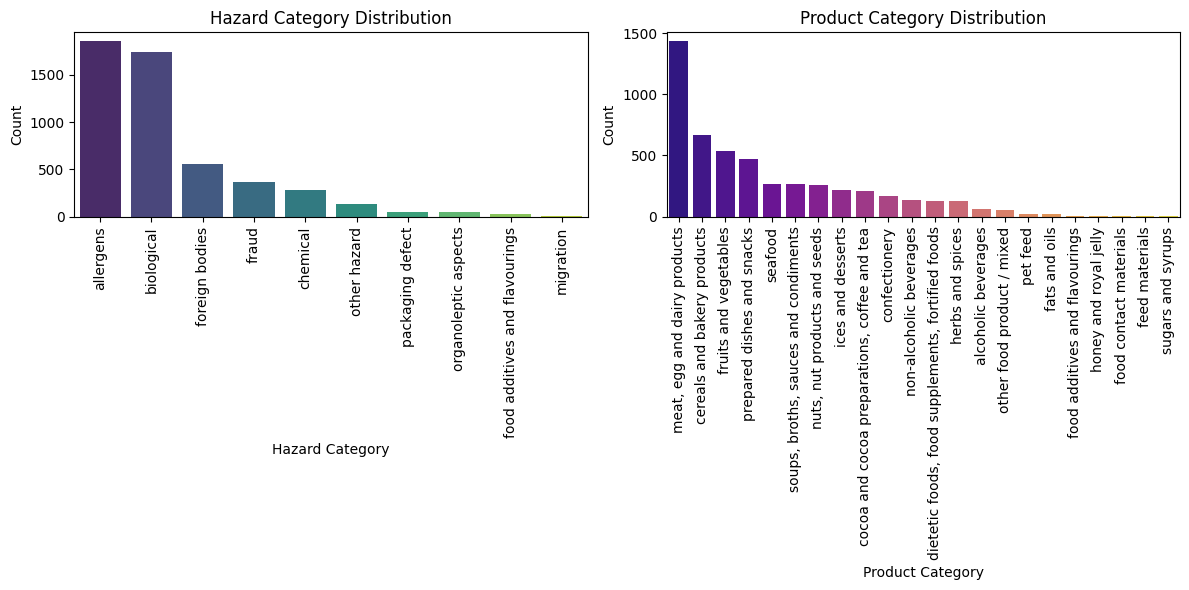

In [16]:
# Step 2: Exploratory Data Analysis
# Class distributions for hazard-category and product-category
hazard_category_counts = train_data_cleaned["hazard-category"].value_counts()
product_category_counts = train_data_cleaned["product-category"].value_counts()

# Plotting class distributions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=hazard_category_counts.index, y=hazard_category_counts.values, palette="viridis")
plt.title("Hazard Category Distribution")
plt.xticks(rotation=90)
plt.xlabel("Hazard Category")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.barplot(x=product_category_counts.index, y=product_category_counts.values, palette="plasma")
plt.title("Product Category Distribution")
plt.xticks(rotation=90)
plt.xlabel("Product Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


 **Class Distributions**

a. **Hazard Categories**:  
The first plot reveals the distribution of the 10 hazard categories (x-axis) and their corresponding counts (y-axis).  
   - Categories such as **"allergens"** and **"biological"** are highly prevalent, dominating the dataset.  
   - Conversely, other categories are significantly underrepresented, indicating an imbalanced distribution of hazard types.

b. **Product Categories**:  
The second plot shows the distribution of the 22 product categories (x-axis) along with their counts (y-axis).  
   - Certain categories, like **"meat, egg and dairy products,"** appear frequently in the dataset.  
   - Similar to the hazard categories, the distribution here is imbalanced, with some product categories occurring much less frequently than others.  




Mean Title Length: 13


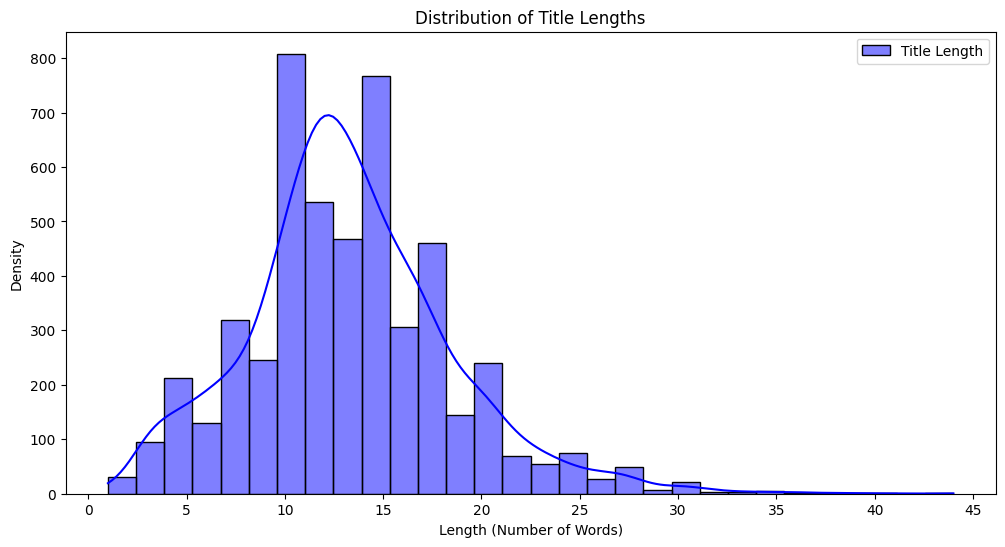

In [17]:
# Text length analysis
title_lengths = train_data_cleaned["title_length"]

# Calculate mean for title length
mean_title_length = train_data_cleaned["title_length"].mean()
print(f"Mean Title Length: {int(mean_title_length)}")


plt.figure(figsize=(12, 6))
sns.histplot(title_lengths, bins=30, kde=True, color="blue", label="Title Length")
plt.xticks(np.arange(0, train_data_cleaned["title_length"].max()+5, 5))  # Customize x-ticks with more intervals
plt.title("Distribution of Title Lengths")
plt.xlabel("Length (Number of Words)")
plt.ylabel("Density")
plt.legend()
plt.show()


**a. Title Lengths Plot**  
   - The histogram for **title lengths** illustrates the distribution of the number of words in the `title` field.                                   
    (x-axis: title length, y-axis: number of titles with each length).  
   - **Observation**:  
     - The distribution shows that most titles have between **5 and 20 words**, reflecting a relatively narrow range of lengths.  
     - The peak in the plot (mode) suggests that the majority of titles are around **10–15 words** long.  
     - The distribution gradually tapers off, with a smaller number of titles exceeding **20 words**.  



Mean Text Length: 353


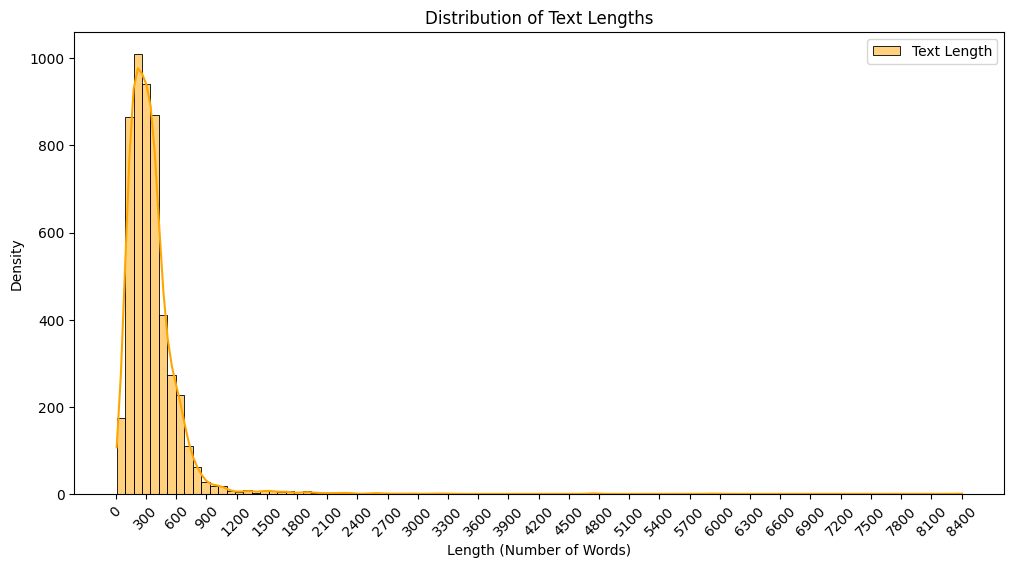

In [18]:
text_lengths = train_data_cleaned["text_length"]

# Calculate mean for text length
mean_text_length = train_data_cleaned["text_length"].mean()
print(f"Mean Text Length: {int(mean_text_length)}" )

#Illustrate the distribution of text lengths
plt.figure(figsize=(12, 6))
sns.histplot(text_lengths, bins=100, kde=True, color="orange", label="Text Length")
plt.xticks(np.arange(0, train_data_cleaned["text_length"].max(), 300), rotation=45)
plt.title("Distribution of Text Lengths")
plt.xlabel("Length (Number of Words)")
plt.ylabel("Density")
plt.legend()
plt.show()



b. **Text Lengths**:  
  - The histogram for **text lengths** illustrates the distribution of the number of words in the `text` field.                                                                         (x-axis: text length, y-axis: number of ttexts with each length ) 
  - **Observation**:  
    - The distribution is much broader compared to titles, with word counts ranging from around **50 to over 600 words**.  
    - A noticeable peak (mode) exists near **300–400 words**, but there is significant variance, as evidenced by the spread of the distribution.  
    - The tail extends toward higher word counts, with some texts exceeding **600 words**.  


### **Summary of Findings from Preprocessing and Exploratoty Data Analysis**

#### **Class Distributions**
1. **Hazard Categories**:
   - Some categories dominate the dataset.
   - Others are underrepresented, reflecting an imbalanced distribution.

2. **Product Categories**:
   - Categories like "meat, egg and dairy products" appear frequently.
   - Similar imbalances as seen with hazard categories.





#### **Text and Titles Lengths**
1. **Titles**:
   - Typically concise, averaging **13 words**.
   - Ideal for short-text classification tasks.

2. **Texts**:
   - Richer in detail, averaging **350 words**.
   - Suitable for more complex analysis and classification.


**CONCLUSION**
